# <center> Topic 4. Neural Networks with PyTorch

Сегодня вам предстоит на практике познакомиться с основными концептами обучения нейронных сетей с помощью [`PyTorch`](https://pytorch.org/).

Для этого задания вам наверняка потребуется GPU, поэтому рекомендуется использовать [Google Colab](https://colab.research.google.com). Не забудьте поменять среду выполнения (Runtime -> Change Runtime Type и выбрать T4 GPU). Необходимые данные вы можете загрузить на Google Drive и затем использовать их внутри тетрадки.

Для выполнения задания необходимо следовать по этой тетрадке сверху вниз и заполнять недостающее части кода или отвечать на заданные вопросы.

In [1]:
# Импортируем необходимые библиотеки
# Полезно все импорты держать рядом

import random
from os import listdir, path

import numpy as np
from matplotlib import pyplot
from PIL import Image
import torch
from torch import nn
from torch.optim import AdamW, Optimizer
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
# Зафиксируем сид для генератора случайных чисел
# Это полезно для воспроизводимости результатов

RANDOM_SEED = 0xC0FFEE

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [3]:
# Определим девайс для вычислений

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

cuda


# This Cat does not Exist

Будем создавать изображения котов, которых не существует!

In [4]:
# Определим несколько вспомогательных функций


def visualize_images(imgs: torch.Tensor, rows: int = 2):
    imgs = (imgs.transpose(1, 3) + 1) / 2
    cols = imgs.shape[0] // 2 + (imgs.shape[0] % 2)

    # Create a figure to display the images
    fig, axes = pyplot.subplots(rows, cols, figsize=(5, 5))

    # Iterate over the images and display them
    for i, ax in enumerate(axes.flat):
        if i < len(imgs):
            # Display the image
            ax.imshow(imgs[i].cpu().numpy())
            ax.axis("off")  # Turn off axis labels

    # Adjust spacing between images
    pyplot.tight_layout()
    pyplot.axis("off")
    pyplot.show()

## Датасет

Реализуем класс для нашего датасета. В нашем датасете не так много картинок, поэтому может сделать Map-Style датасет. Для этого необходимо определить функции `__getitem__` и `__len__`. Первая отвечает за загрузку отдельного элемента датасета, изображения, а вторая возвращает длину датасета.

In [5]:
!unzip /content/cat_136.zip

Streaming output truncated to the last 5000 lines.
  inflating: cat_136/flickr_cat_000168.jpg  
  inflating: cat_136/flickr_cat_000169.jpg  
  inflating: cat_136/flickr_cat_000170.jpg  
  inflating: cat_136/flickr_cat_000171.jpg  
  inflating: cat_136/flickr_cat_000172.jpg  
  inflating: cat_136/flickr_cat_000173.jpg  
  inflating: cat_136/flickr_cat_000178.jpg  
  inflating: cat_136/flickr_cat_000179.jpg  
  inflating: cat_136/flickr_cat_000181.jpg  
  inflating: cat_136/flickr_cat_000185.jpg  
  inflating: cat_136/flickr_cat_000186.jpg  
  inflating: cat_136/flickr_cat_000187.jpg  
  inflating: cat_136/flickr_cat_000188.jpg  
  inflating: cat_136/flickr_cat_000189.jpg  
  inflating: cat_136/flickr_cat_000190.jpg  
  inflating: cat_136/flickr_cat_000192.jpg  
  inflating: cat_136/flickr_cat_000193.jpg  
  inflating: cat_136/flickr_cat_000194.jpg  
  inflating: cat_136/flickr_cat_000195.jpg  
  inflating: cat_136/flickr_cat_000196.jpg  
  inflating: cat_136/flickr_cat_000197.jpg  
  in

In [6]:
class CatDataset(Dataset):
    """Dataset for cats.
    Read images from disk, convert them to a torch tensor, and resize them to equal squares.

    :path_to_dataset str: path to directory with images
    :size int: size of output images
    """

    def __init__(self, path_to_dataset: str = "cat_136", size: int = 64, crop_rate: int = 32):
        self.path_base = path_to_dataset
        self.size = size
        self.crop_rate = crop_rate
        self.photo_names = listdir(path_to_dataset)
        print(f"Found {len(self.photo_names)} images")

    def __getitem__(self, index: int) -> torch.Tensor:
        """Load image from disk and prepare for training.

        :index int: index of image to load
        :return Tensor: torch Tensor with image, shape: [3; self.size; self.size]
        """
        # 1. Load image from disk, create Tensor
        image_path = path.join(self.path_base, self.photo_names[index])
        with Image.open(image_path) as img:
            data = np.array(img)  # 136 x 136 x 3
            width, height = data.shape[0], data.shape[1]
        image = torch.from_numpy(data)

        # 2. Random cropping to make images more varied:
        #    1. Generate crop for X and Y axis from 0 to self.crop_rate
        #    2. Cut cropped parts from image -- tensor slicing
        l, r, b, h = torch.randint(0, self.crop_rate, (4, ))

        image_sl = image[l : width - r, b : height - h]

        # 3. Make the image of the required size via F.interpolate
        #    - Channels should be the first dimmension, so transpose 0 and 2 dim
        #    - Interpolate accepts batched input, use `unsqueeze` ans `squeeze` to add and remove dim
        image_sl = image_sl.transpose(0, 2)
        image_sl = image_sl.unsqueeze(0)
        image_sl = F.interpolate(image_sl, size=[self.size, self.size])
        image_sl = image_sl.squeeze(0)

        # 4. Normalize image to be in range [-1; 1] instead of [0; 255]
        image_sl = image_sl / (255 / 2) - 1

        return image_sl

    def __len__(self) -> int:
        """Return size of dataset

        :return int: size of dataset
        """
        return len(self.photo_names)

Found 5153 images


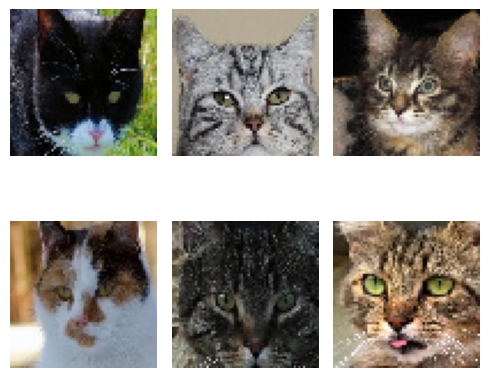

In [7]:
dataset = CatDataset(size=64)
random_images = torch.stack([dataset[i] for i in [3, 15, 182, 592, 394, 2941]], dim=0)
assert list(random_images.shape) == [
    6,
    3,
    64,
    64,
], f"Icorrect shape of images: {random_images[0].shape}, should be [3, 64, 64]"
assert all([-1.0 <= it <= 1.0 for it in random_images.flatten()]), f"Incorrect image normalization"

visualize_images(random_images)

## Модель
Для генерации котов реализуем нейронную сеть типа **GAN**, а именно: **DCGAN**. Модели этого типа состоят из 2 отдельных блоков: генератор и дискриминатор.
Цель генератора — это по случайному шуму генерировать картинку, а дискриминатора — отличать сгенерированную от настоящей.
Каждый блок — это отдельная нейронная сеть, а их выход используется в качестве функции потери у другой!

### Генератор

Для начала реализуем генератор. Предлагается использовать следующую архитектуру:

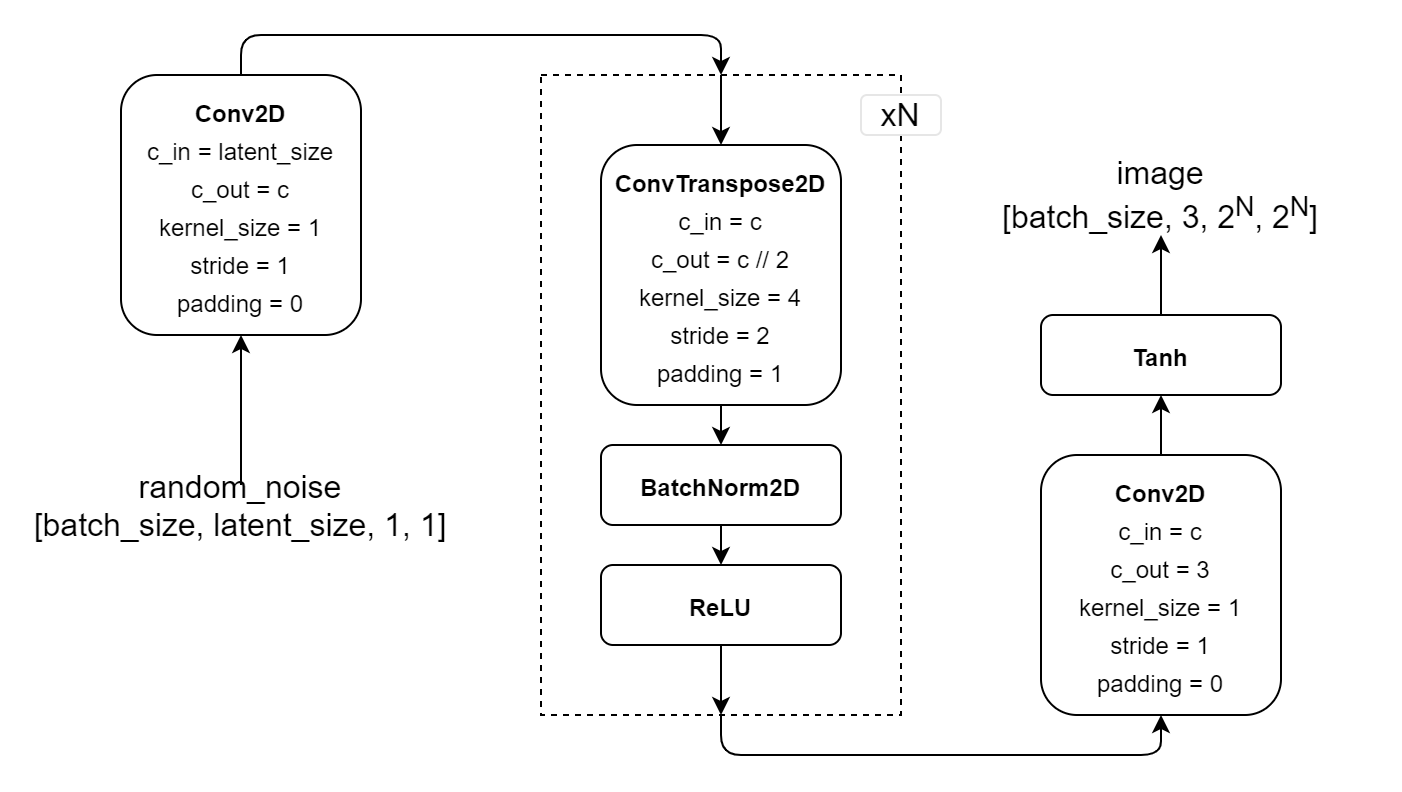![](/content/imgs/DCGAN.png)

Для ее реализации вам потребуются модули `nn.BatchNorm2d`, `nn.Conv2d`, `nn.ConvTranspose2D`, `nn.ReLU`.

In [9]:
def random_noise(batch_size: int, channels: int, side_size: int, *, device: torch.device = None) -> torch.Tensor:
    """Generate random noise for batch of images with given size and number of channels."""
    return torch.randn(batch_size, channels, side_size, side_size, device=device)


class Generator(nn.Module):
    """Neural network to generate image from noise

    :start_size int: size of randomized image
    :latent_size int: size of latent size, i.e. number of channels in randomized images
    :upsampling int: number of layers
    :start_channels int: number of hidden channels, reduced by 2 in each block
    """

    def __init__(self, start_size: int = 2, latent_size: int = 32, upsamplings: int = 6, start_channels: int = 1024):
        super().__init__()
        self.start_size = start_size
        self.latent_size = latent_size
        self.start_channels = start_channels
        self.upsamplings = upsamplings

        self.generator = nn.Sequential(*self.get_modules())

    def get_modules(self) -> list[nn.Module]:
        """Create list of modules for specified hyperparameters

        :return list: list of modules
        """
        latent_channels = self.start_channels
        modules = []
        modules.append(nn.Conv2d(in_channels=self.latent_size, out_channels=self.start_channels,
                                kernel_size=1, stride=1, padding=0))

        for _ in range(self.upsamplings):
            modules.append(nn.ConvTranspose2d(in_channels=latent_channels,
                                             out_channels = latent_channels // 2,
                                             kernel_size = 4,
                                             stride = 2, padding = 1))
            latent_channels //= 2

            modules.append(nn.BatchNorm2d(num_features=latent_channels))
            modules.append(nn.ReLU())

        modules.append(nn.Conv2d(in_channels=latent_channels, out_channels=3,
                                kernel_size = 1, stride = 1, padding = 0))
        modules.append(nn.Tanh())

        return modules


    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, batch_size: int) -> torch.Tensor:
        """Generate batch of faked images

        :batch_size int: number of images to generate
        :return Tensor: Tensor w/ generated images, shape [batch size; 3; end size; end size]
        """
        # 1. Generate random noise of starting shape via `random_noise` func
        r_noise = random_noise(batch_size, self.latent_size, self.start_size, device=self.device)
        # 2. Generate random images
        images = self.generator(r_noise)
        return images

### Дискриминатор
Теперь реализуем дискриминатор, его задача по картинке предсказывать 1 класс -- реальное или фейковое изображение.

Предлагается использовать следующую архитектуру:

![](https://github.com/SpirinEgor/HSE.machine_learning/blob/main/06.%20This%20Cat%20Does%20Not%20Exist/imgs/Disc_DCGAN.png?raw=1)

Для ее реализации вам потребуются модули `nn.BatchNorm2d`, `nn.Conv2d`, `nn.ReLU` и `nn.Sigmoid`.

In [10]:
class Discriminator(nn.Module):
    """Neural network to classify image

    :downsamplings int: number of layers
    :start_channels int: number of hidden channels, increased by 2 in each block
    """

    def __init__(self, downsamplings: int = 6, start_channels: int = 8, size: int = 128):
        super().__init__()
        self.downsamplings = downsamplings
        self.start_channels = start_channels
        self.size = size


        self.discriminator = nn.Sequential(*self.get_modules())

    def get_modules(self) -> list[nn.Module]:
        """Create list of modules for specified hyperparameters

        :return list: list of modules
        """
        modules = []
        c = self.start_channels
        modules.append(nn.Conv2d(in_channels=3, out_channels=c, kernel_size=1, stride=1, padding=0))

        for _ in range(self.downsamplings):
            modules.append(nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=3, stride=2, padding=1))
            modules.append(nn.BatchNorm2d(num_features=c*2))
            modules.append(nn.ReLU())
            c *= 2

        modules.append(nn.Flatten())

        h = b = self.size // 2 ** self.downsamplings

        modules.append(nn.Linear(in_features=c * b * h, out_features=1))
        modules.append(nn.Sigmoid())

        return modules


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Predict class for images

        :x Tensor: input batch of images, shape [batch size; 3; H; W]
        :return Tensor: output batch of probabilities, shape [batch size; 1]
        """

        probabilities = self.discriminator(x)
        return probabilities

## Обучение

Будем обучать GAN несколько эпох, при этом каждый шаг обучения состоит из 3 действий:
1. Позитивный шаг для дискриминатора: используем реальные картинки
2. Негативный шаг для дискриминатора: используем сгенерированные картинки
3. Шаг генератора: генерируем картинки, считаем предсказания дискриминатора, используем для обновления генератора.

Во время обучения будем следить за лоссом и дискриминатора, и генератора. При этом тренд лоссов будет немного необычным: сначала будет обучаться дискриминатор, как только он начнет улавливать суть изображений, то и генератор станет обучаться. Однако чем качественнее генератор создает картинки, тем сложнее дискриминатору их различить и его лосс начинает расти.

In [11]:
class GANTrainer:
    """Trainer for basic GAN on specified dataset"""

    def __init__(self, generator, discriminator, dataset, device):
        self.generator = generator.to(device)
        self.discriminator = discriminator.to(device)
        self.dataset = dataset

        self.device = device

    def configure_optimizers(
        self, learning_rate: float, weight_decay: float = 1e-2, betas: tuple[float] = (0.5, 0.999)
    ) -> tuple[Optimizer]:
        """Create SEPARATE AdamW optimizers for generator and discriminator.
        Input arguments are for torch.optim.AdamW optimizers.

        :return tuple: optimizer for generator, optimizer for discriminator
        """
        gen_opt = torch.optim.AdamW(params=self.generator.parameters(),
                                    lr=learning_rate,
                                    weight_decay=weight_decay,
                                    betas=betas)
        discr_opt = torch.optim.AdamW(params=self.discriminator.parameters(),
                                    lr=learning_rate,
                                    weight_decay=weight_decay,
                                    betas=betas)
        return gen_opt, discr_opt

    def configure_dataloader(self, batch_size: int, shuffle: bool) -> DataLoader:
        """Create dataloader for dataset with specified batch size"""
        return DataLoader(self.dataset, batch_size, shuffle)

    def discriminator_update(self, batch: torch.Tensor, disc_optim: Optimizer, is_positive: bool) -> float:
        """Update step for discriminator

        :batch Tensor: tensor of images for training, shape: [bs; 3; H; W]
        :disc_optim Optimizer: Optimizer for Discriminator
        :is_positive bool: whether batch of images is fake or real
        :return float: loss on passed batch
        """
        # 1. Set gradients to zero
        disc_optim.zero_grad()

        # 2. Make predictions
        predicts = self.discriminator(batch)

        # 3. Create target values based on `is_positive`
        #    If the batch is fake, all labels will be zeros, otherwise - ones.
        targets = torch.full_like(predicts, int(is_positive))

        # 4. Calculate loss based on F.binary_cross_entropy
        loss = F.binary_cross_entropy(predicts, targets)

        # 5. Calculate gradients
        loss.backward()

        # 6. Update weights
        disc_optim.step()

        # 7. Convert loss to float
        loss = loss.item()
        return loss

    def generator_update(self, batch_size: int, gen_optim: Optimizer) -> float:
        """Update step for generator

        :batch_size int: Number of images to generate for training
        :gen_optim Optimizer: Optimizer for Generator
        :return float: loss on passed batch
        """
        # 1. Set gradients to zero
        gen_optim.zero_grad()

        # 2. Generate images
        images = self.generator(batch_size)

        # 3. Predict image classes:
        predicts = self.discriminator(images)

        # 4. Create target values: we want to trick discrimator
        #    - all fake images should be classified as real
        targets = torch.ones_like(predicts)

        # 5. Calculate loss based on F.binary_cross_entropy
        loss = F.binary_cross_entropy(predicts, targets)

        # 6. Calculate gradients
        loss.backward()

        # 7. Update weights
        gen_optim.step()

        # 8. Convert loss to float
        loss = loss.item()
        return loss

    def run_epoch(self, dataloader, gen_optim, disc_optim) -> tuple[float, float]:
        gen_loss_mean, disc_loss_mean = 0.0, 0.0

        for batch in tqdm(dataloader):
            batch = batch.to(self.device, non_blocking=True)

            # Positive update
            disc_loss_mean += self.discriminator_update(batch, disc_optim, is_positive=True)

            # Negative update
            with torch.no_grad():
                fake_batch = self.generator(batch.shape[0])
            disc_loss_mean += self.discriminator_update(fake_batch, disc_optim, is_positive=False)

            # Generator update
            gen_loss_mean += self.generator_update(batch.shape[0], gen_optim)

        gen_loss_mean /= len(dataloader)
        disc_loss_mean /= len(dataloader)
        return gen_loss_mean, disc_loss_mean

    def train(
        self, n_epochs: int = 50, batch_size: int = 8, learning_rate: float = 1e-4, visualize_every_epoch: int = 10
    ):
        gen_optim, disc_optim = self.configure_optimizers(learning_rate)
        dataloader = self.configure_dataloader(batch_size, shuffle=True)

        for epoch in range(n_epochs):
            gen_loss_mean, disc_loss_mean = self.run_epoch(dataloader, gen_optim, disc_optim)

            if (epoch + 1) % visualize_every_epoch == 0:
                with torch.no_grad():
                    fake_images = self.generator(6)
                visualize_images(fake_images, rows=2)

            print(f"Epoch {epoch+1} | Discriminator loss: {disc_loss_mean:.4f} | Generator loss: {gen_loss_mean:.4f}")

In [12]:
generator = Generator()
discriminator = Discriminator()
dataset = CatDataset(size=128)

trainer = GANTrainer(generator, discriminator, dataset, device)

Found 5153 images


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 1 | Discriminator loss: 0.1654 | Generator loss: 5.3079


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 2 | Discriminator loss: 0.1711 | Generator loss: 5.4907


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 3 | Discriminator loss: 0.8385 | Generator loss: 2.6387


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 4 | Discriminator loss: 0.9129 | Generator loss: 2.3154


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 5 | Discriminator loss: 1.0885 | Generator loss: 1.8658


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 6 | Discriminator loss: 1.0344 | Generator loss: 1.9148


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 7 | Discriminator loss: 1.0290 | Generator loss: 1.8137


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 8 | Discriminator loss: 1.0347 | Generator loss: 1.6792


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 9 | Discriminator loss: 1.0073 | Generator loss: 1.7347


  0%|          | 0/645 [00:00<?, ?it/s]

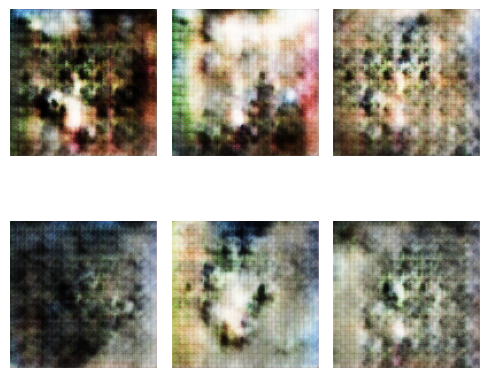

Epoch 10 | Discriminator loss: 0.9924 | Generator loss: 1.7390


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 11 | Discriminator loss: 0.9415 | Generator loss: 1.7878


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 12 | Discriminator loss: 0.8807 | Generator loss: 1.9454


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 13 | Discriminator loss: 0.8289 | Generator loss: 2.1354


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 14 | Discriminator loss: 0.7730 | Generator loss: 2.1299


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 15 | Discriminator loss: 0.7614 | Generator loss: 2.2359


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 16 | Discriminator loss: 0.7022 | Generator loss: 2.3942


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 17 | Discriminator loss: 0.6596 | Generator loss: 2.4195


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 18 | Discriminator loss: 0.6646 | Generator loss: 2.5954


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 19 | Discriminator loss: 0.6418 | Generator loss: 2.5167


  0%|          | 0/645 [00:00<?, ?it/s]

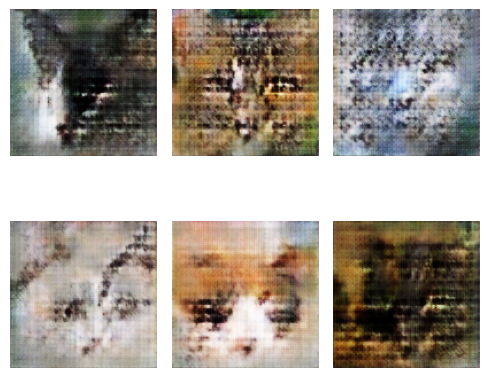

Epoch 20 | Discriminator loss: 0.6285 | Generator loss: 2.6338


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 21 | Discriminator loss: 0.6328 | Generator loss: 2.7347


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 22 | Discriminator loss: 0.6282 | Generator loss: 2.5734


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 23 | Discriminator loss: 0.6174 | Generator loss: 2.6912


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 24 | Discriminator loss: 0.6089 | Generator loss: 2.6843


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 25 | Discriminator loss: 0.6182 | Generator loss: 2.7024


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 26 | Discriminator loss: 0.5571 | Generator loss: 2.7656


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 27 | Discriminator loss: 0.5592 | Generator loss: 2.9230


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 28 | Discriminator loss: 0.5424 | Generator loss: 3.0169


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 29 | Discriminator loss: 0.5254 | Generator loss: 3.0219


  0%|          | 0/645 [00:00<?, ?it/s]

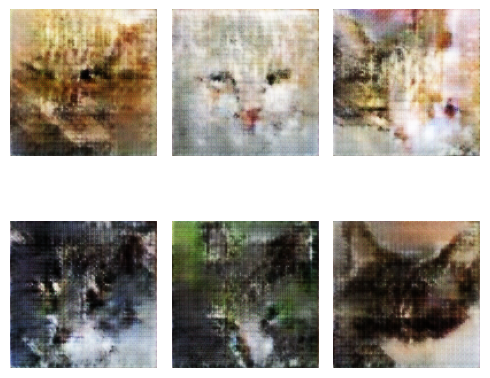

Epoch 30 | Discriminator loss: 0.5322 | Generator loss: 3.0445


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 31 | Discriminator loss: 0.5374 | Generator loss: 3.0128


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 32 | Discriminator loss: 0.5111 | Generator loss: 3.1261


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 33 | Discriminator loss: 0.4878 | Generator loss: 3.1159


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 34 | Discriminator loss: 0.4911 | Generator loss: 3.2039


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 35 | Discriminator loss: 0.4872 | Generator loss: 3.2373


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 36 | Discriminator loss: 0.4673 | Generator loss: 3.2827


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 37 | Discriminator loss: 0.4729 | Generator loss: 3.3954


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 38 | Discriminator loss: 0.4363 | Generator loss: 3.3171


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 39 | Discriminator loss: 0.4681 | Generator loss: 3.2985


  0%|          | 0/645 [00:00<?, ?it/s]

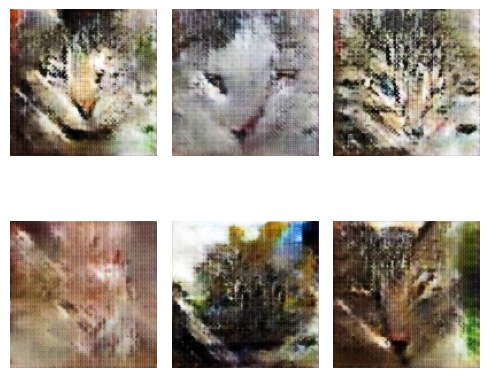

Epoch 40 | Discriminator loss: 0.4279 | Generator loss: 3.3496


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 41 | Discriminator loss: 0.4441 | Generator loss: 3.5233


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 42 | Discriminator loss: 0.4396 | Generator loss: 3.3401


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 43 | Discriminator loss: 0.3926 | Generator loss: 3.5687


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 44 | Discriminator loss: 0.4363 | Generator loss: 3.3966


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 45 | Discriminator loss: 0.4202 | Generator loss: 3.5247


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 46 | Discriminator loss: 0.4262 | Generator loss: 3.6128


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 47 | Discriminator loss: 0.4116 | Generator loss: 3.5788


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 48 | Discriminator loss: 0.4124 | Generator loss: 3.6006


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 49 | Discriminator loss: 0.4054 | Generator loss: 3.6006


  0%|          | 0/645 [00:00<?, ?it/s]

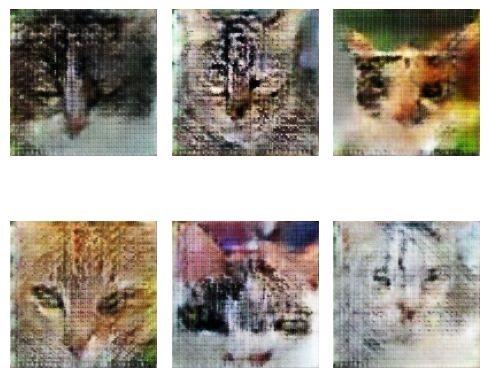

Epoch 50 | Discriminator loss: 0.4003 | Generator loss: 3.5808


In [13]:
trainer.train(n_epochs=50, batch_size=8, visualize_every_epoch=10)

## Сохранение модели

После обучения модели необходимо сохранить модель, создадим общий чекпоинт с дискриминатором и генератором.

Для этого будут полезны метод `state_dict` у любого модуля в Torch и функция `torch.save`.

In [28]:
def dump_checkpoint(generator: Generator, discriminator: Discriminator, filename: str):
    """Save modules to specified file.
    Checkpoint contains dict with state dicts for Generator and Discriminator along with their hyperparameters.
    """
    checkpoint = {
        'gen_state_dict': generator.state_dict(),
        'gen_hyperparams': {
            'start_size': generator.start_size,
            'latent_size': generator.latent_size,
            'upsamplings': generator.upsamplings,
            'start_channels': generator.start_channels
        },
        'discr_state_dict': discriminator.state_dict(),
        'discr_hyperparams': {
            'downsamplings': discriminator.downsamplings,
            'start_channels': discriminator.start_channels,
            'size': discriminator.size
        }
    }

    torch.save(checkpoint, filename)

    print(f"Checkpoint saved to file {filename}")

In [29]:
dump_checkpoint(generator, discriminator, "checkpoint.pt")

Checkpoint saved to file checkpoint.pt


# Загрузка модели

Проверим, что модель загружается с диска и работает.

Для этого будут полезны методы `load_state_dict` у любого модуля в Torch и функция `torch.load`.

In [30]:
def load_checkpoint(filename: str) -> tuple[Generator, Discriminator]:
    """Load modules from specified file."""
    # 1. Load checkpoint from specified filename
    checkpoint = torch.load(filename, weights_only=True)
    # 2. Init Generator with hyperparameters from checkpoint
    generator = Generator(**checkpoint['gen_hyperparams'])
    # 3. Load state dict for Generator
    gen_state_dict = checkpoint['gen_state_dict']
    generator.load_state_dict(gen_state_dict)
    # 4. Init Discriminator with hyperparameters from checkpoint
    dicriminator = Discriminator(**checkpoint['discr_hyperparams'])
    # 5. Load state dict for Discriminator
    discr_state_dict = checkpoint['discr_state_dict']
    dicriminator.load_state_dict(discr_state_dict)

    return generator, discriminator

In [31]:
generator, discriminator = load_checkpoint("checkpoint.pt")
generator = generator.to(device)
discriminator = discriminator.to(device)

Predicted classes: REAL, REAL, REAL, REAL, REAL, REAL


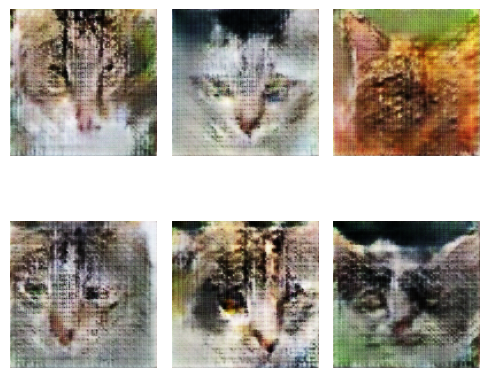

In [32]:
with torch.inference_mode():
    fake_images = generator(6)
    probs = discriminator(fake_images)
    prediction = [["FAKE", "REAL"][i > 0.5] for i in probs]

print(f"Predicted classes: {', '.join(prediction)}")
visualize_images(fake_images)

При сдаче практики также прикрепите полученный чекпоинт!